In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import Rbf
from scipy.interpolate import interp1d
from scipy.ndimage import filters, morphology #For minimum finding
from scipy.signal import argrelextrema
import time

In [2]:
### potential surfaces
def V_sin(x,y,ax,ay):
    result = ax*np.cos(2.0*np.pi*x) + ay*np.cos(2.0*np.pi*y) 
    return(result)
def Q(r,d,alpha,r0):
    result = 0.5*d*(1.5*np.exp(-2.0*alpha*(r-r0)) - np.exp(-alpha*(r-r0)))
    return(result)
def J(r,d,alpha,r0):
    result = 0.25*d*(np.exp(-2.0*alpha*(r-r0)) - 6.0*np.exp(-alpha*(r-r0)) )
    return(result)
def V_LEPS(rAB,rBC,rAC,a,b,c,dab,dbc,dac,alpha,r0):
    V1 =  Q(rAB,dab,alpha,r0)/(1 + a) + Q(rBC,dbc,alpha,r0)/(1+b) + Q(rAC,dac,alpha,r0)/(1+c)
    V2 = np.sqrt((J(rAB,dab,alpha,r0)/(1+a))**2 + (J(rBC,dbc,alpha,r0)/(1+b))**2 + 
                 (J(rAC,dac,alpha,r0)/(1+c))**2 - J(rAB,dab,alpha,r0)*J(rBC,dbc,alpha,r0)/((1+a)*(1+b)) - 
                 J(rAC,dac,alpha,r0)*J(rBC,dbc,alpha,r0)/((1+b)*(1+c)) 
                 - J(rAB,dab,alpha,r0)*J(rAC,dac,alpha,r0)/((1+a)*(1+c)) )
    V = V1 - V2
    return(V)
def V_HO_LEPS(rAB,x):
    rAC = 3.742
    a = .05
    b = .80
    c = .05
    dab = 4.746
    dbc = 4.746
    dac = 3.445
    r0 = 0.742
    alpha = 1.942
    kc = .2025
    c2 = 1.154
    V1 = V_LEPS(rAB,rAC-rAB,rAC,a,b,c,dab,dbc,dac,alpha,r0)
    V2 = 2.0*kc*(rAB - (0.5*rAC - x/c2))**2
    result = V1 + V2 
    return(result)
def V_Syl(x,y):
    A = -0.8447
    B = -0.2236
    C = 0.1247
    D = -4.468
    E = 0.02194
    F = 0.3041
    G = 0.1687
    H = 0.4388
    I = -4.713 * 10**(-7)
    J = -1.148 * 10**(-5)
    K = 1.687
    L = -3.062 * 10**(-18)
    M = -9.426 * 10**(-6)
    N = -2.851 * 10**(-16)
    O = 2.313 * 10**(-5)
    
    vOut = A + B*x + C*y + D*x**2 + E*x*y + F*y**2 + G*x**3 + H*x**2*y
    vOut += I*x*y**2 + J*y**3 + K*x**4 + L*x**3*y + M*x**2*y**2 + N*x*y**3 + O*y**4
    return vOut
def action(path,V,minimum):
    x_coords = path[:,0]
    y_coords = path[:,1]
    a = 0
    for i in np.arange(0,len(x_coords),1):
        if i== len(x_coords)-1:
            pass
        else:
            a += np.sqrt((V(x_coords[i],y_coords[i])- minimum)*((x_coords[i+1] - x_coords[i]) ** 2 + 
                                                                (y_coords[i+1] - y_coords[i]) ** 2))
    return a
def energy(V,path,minimum):
    total = 0
    for point in path:
        total += V(point[0],point[1]) - minimum
    return(total)
def grad_2d(f,x,y):
    h = 10**(-8)
    ### assumes a 2-dim function f(x,y)
    df_dx = (f(x+h/2,y) - f(x-h/2,y))/h
    df_dy = (f(x,y+h/2) - f(x,y-h/2))/h
    return(df_dx,df_dy)

def eps(V,x,y,m,E_gs):
    result = np.sqrt(2*m*(V(x,y) - E_gs))
    return(result)

def get_init_path(R0,RN,N):
    ## returns the initial positions of every point on the chain.
    x_coords = np.linspace(R0[0],RN[0],N)
    y_coords = np.linspace(R0[1],RN[1],N)
    path = np.stack((x_coords,y_coords),axis=1)
    return(path)
def get_tang_vect(int_path,V):
    #returns array of tangen vectors for each point on the chain. The position of each is given by chain coords. 
    #each row is the ith tangent vector directional information. 
    tan_vects = []
    for i in np.arange(0,len(int_path),1):
        if i==0:
            tan = (int_path[i+1] - int_path[i])
        else:
            if i==len(int_path)-1:
                tan = (int_path[i] - int_path[i-1])
            else:
                Vip1 = V(int_path[i+1][0],int_path[i+1][1])
                Vi = V(int_path[i][0],int_path[i][1])
                Vim1 =V(int_path[i-1][0],int_path[i-1][1])
                if (Vip1 > Vi) and (Vi > Vim1): 
                    tan = int_path[i+1] - int_path[i]
                elif (Vip1 < Vi) and (Vi < Vim1): 
                    tan = int_path[i] - int_path[i-1]
                elif (Vip1 < Vi) and (Vi > Vim1) or (Vip1 > Vi) and (Vi < Vim1): 
                    delta_V_min = min(abs(Vip1 - Vi),abs(Vim1 - Vi))
                    delta_V_max = max(abs(Vip1 - Vi),abs(Vim1 - Vi))
                    if Vip1 > Vim1:
                        tan = (int_path[i+1] - int_path[i])*delta_V_max + (int_path[i] - int_path[i-1])*delta_V_min
                    else: 
                        tan = (int_path[i+1] - int_path[i])*delta_V_min + (int_path[i] - int_path[i-1])*delta_V_max
                else:pass
        norm = np.linalg.norm(tan)
        tan = tan/norm
        tan_vects.append(tan)
    tan_vects = np.array(tan_vects)
    return(tan_vects)
def F_s(k,R,tan_vects):
    #returns 2d-array calculating force at each image.
    # R is an array of the position vectors on the chain. each ith row is assumed to be R_{i}
    force = []
    for i in np.arange(0,len(R),1):
        if i==0:
            force.append(np.zeros((1,2))[0])
        else:
            if i==len(R)-1:
                force.append(np.zeros((1,2))[0])
            else:
                result = k*(np.linalg.norm(R[i+1] - R[i]) - np.linalg.norm(R[i]  - R[i-1]))*tan_vects[i]
                force.append(result)
    force = np.array(force)
    return(force)
def F_r_finite(V,R,tan):
    ## gives the "real" force on each image
    force = []
    for i in np.arange(0,len(R),1):
        if i==0:
            force.append(np.zeros((1,2))[0])
        else:
            if i==len(R)-1:
                force.append(np.zeros((1,2))[0])
            else:
                grad_Vx,grad_Vy = grad_2d(V,R[i][0],R[i][1])
                grad_V = np.array((grad_Vx,grad_Vy))
                result = -grad_V + np.dot(grad_V,tan[i])*tan[i]
                force.append(result)
    force = np.array(force)    
    return(force)
def g_perp(V,path,m,tau,E_gs,E_const,k,kappa,fix_r0,fix_rn):
    N_idx = np.arange(0,len(path),1)
    g_perp= np.zeros((len(N_idx),2))
    E = eps(V,path[:,0],path[:,1],m,E_gs)
    for i in N_idx:
        if i==0:
            if fix_r0 is not False:
                g_perp[i] = np.zeros((1,2))[0]
            else:
                g_spr_0 = k*(path[i+1]-path[i])
                f = -1*np.array(grad_2d(V,path[i][0],path[i][1]))
                f_norm = np.linalg.norm(f)
                g_perp[i] = g_spr_0 - (np.dot(g_spr_0,f/f_norm) - kappa*(V(path[i][0],path[i][1]) - E_const))*f/f_norm
        elif i==len(N_idx)-1:
            if fix_rn is not False:
                g_perp[i] = np.zeros((1,2))[0]
            else:
                g_spr_0 = k*(path[i]-path[i-1])
                f = -1*np.array(grad_2d(V,path[i][0],path[i][1]))
                f_norm = np.linalg.norm(f)
                g_perp[i] = g_spr_0 - (np.dot(g_spr_0,f/f_norm) - kappa*(V(path[i][0],path[i][1]) - E_const))*f/f_norm
        else:
            f = -1*np.array(grad_2d(V,path[i][0],path[i][1]))
            d_i = np.linalg.norm(path[i] - path[i-1])
            d_ip1 = np.linalg.norm(path[i+1] - path[i])
            d_ivec = (path[i] - path[i-1])/d_i
            d_ip1vec = (path[i+1] - path[i])/d_ip1
            g_i =.5*((m/E[i])*(d_i + d_ip1)*f - (E[i] + E[i-1])*d_ivec + (E[i+1] + E[i])*d_ip1vec) 
            g_perp[i] = g_i - np.dot(g_i,tau[i])*tau[i]
    return(g_perp) 
def NEB_LAP(V,init_path,E_gs,E_const,M,N,dt,k,kappa,fix_r0=False,fix_rn=False,FIRE=False):
    ### Initialize the initial path. R0 is the starting point on V and RN is the end point
    action_array = np.zeros((M))
    energies = np.zeros((M))
    ### Initialize the path array
    path = np.full((M,N,2),init_path)
    ### Initialize the velocities, masses, and shift arrays for the QM Verlet Algorithm 
    v = np.full((M,N,2),np.zeros(init_path.shape))
    vp = np.full((M,N,2),np.zeros(init_path.shape))
    a = np.full((M,N,2),np.zeros(init_path.shape))
    mass = np.full(init_path.shape[0],1)
    shift = np.full((M,N,2),np.zeros(init_path.shape))
    min_fire=10
    dtmax=10.0
    dtmin=0.1
    finc=1.1
    fdec=0.5
    fadec=0.99
    alpha_st=0.1
    alpha=alpha_st
    maxmove=0.2
    fire_steps=0
    #### MAIN KERNEL (QM Verlet)
    for i in np.arange(0,M,1):
        ## calculate the new tangent vectors and forces after each shift.
        tau = get_tang_vect(path[i],V)
        F_spring = F_s(k,path[i],tau)
        g = g_perp(V,path[i],1.0,tau,E_gs,E_const,k,kappa,fix_r0,fix_rn)
        F =  F_spring + g
        for j in np.arange(0,N,1):
            if i==0:
                vp[i][j]= np.zeros(v[i][j].shape)
            else:
                if i==M-1:
                    pass
                else:
                    if(not FIRE):
                        prod = np.dot(v[i-1][j],F[j])
                        if prod > 0:
                            vp[i][j]= prod*F[j]/np.linalg.norm(F[j])
                        else:
                            vp[i][j] = np.zeros(v[i][j].shape)
                        a[i][j] = F[j]/mass[j] 
                        v[i][j] = vp[i][j] + dt*a[i][j]
                        shift[i][j] = v[i][j]*dt + .5*a[i][j]*dt**2
                        path[i+1][j] = path[i][j] + shift[i][j]
                    else:
                        prod = np.dot(F[j],v[i-1][j])
                        #print(prod)
                        if prod > 0:
                            vp[i][j]= (1.0 - alpha)*v[i-1][j]+alpha*np.linalg.norm(v[i-1][j])*F[j]/np.linalg.norm(F[j])
                            if(fire_steps > min_fire):
                                dt = min(dt*finc,dtmax)
                                alpha=alpha*fadec
                                #print("PROD+ dt, alpha: ",dt,alpha)

                            fire_steps+=1
                        else:
                            vp[i][j] = np.zeros(v[i][j].shape)
                            alpha=alpha_st
                            dt=max(dt*fdec,dtmin)
                            fire_steps=0
                            #print("PROD- dt, alpha: ",dt,alpha)
                        v[i][j] = vp[i][j] + dt*F[j]
                        shift[i][j] = v[i][j]*dt + 0.5*F[j]/mass[j]*dt**2
                        if(np.linalg.norm(shift[i][j])>maxmove):
                            shift[i][j] = maxmove*shift[i][j]/np.linalg.norm(shift[i][j])
                        path[i+1][j] = path[i][j] + shift[i][j]
        action_array[i] = action(path[i],V,E_gs)
        energies[i] = energy(V,path[i],E_gs)
    return(path[-1],action_array,energies,path)
def NEB_MEP(V,init_path,E_gs,M,N,dt,k):
    ### Initialize the initial path. R0 is the starting point on V and RN is the end point
    action_array = np.zeros((M))
    energies = np.zeros((M))
    ### Initialize the path array
    path = np.full((M,N,2),init_path)
    ### Initialize the velocities, masses, and shift arrays for the QM Verlet Algorithm 
    v = np.full((M,N,2),np.zeros(init_path.shape))
    vp = np.full((M,N,2),np.zeros(init_path.shape))
    a = np.full((M,N,2),np.zeros(init_path.shape))
    mass = np.full(init_path.shape[0],1)
    shift = np.full((M,N,2),np.zeros(init_path.shape))
    #### MAIN KERNEL (QM Verlet)
    for i in np.arange(0,M,1):
        ## calculate the new tangent vectors and forces after each shift.
        tau = get_tang_vect(path[i],V)
        F_spring = F_s(k,path[i],tau)
        F_real = F_r_finite(V,path[i],tau)
        F =  F_spring + F_real
        for j in np.arange(0,N,1):
            if i==0:
                vp[i][j]= np.zeros(v[i][j].shape)
            else:
                if i==M-1:
                    pass
                else:
                    prod = np.dot(v[i-1][j],F[j])
                    if prod > 0:
                        vp[i][j]= prod*F[j]/np.linalg.norm(F[j])
                    else:
                        vp[i][j] = np.zeros(v[i][j].shape)
                    a[i][j] = F[j]/mass[j] 
                    v[i][j] = vp[i][j] + dt*a[i][j]
                    shift[i][j] = v[i][j]*dt + .5*a[i][j]*dt**2
                    path[i+1][j] = path[i][j] + shift[i][j]
        action_array[i] = action(path[i],V,E_gs)
        energies[i] = energy(V,path[i],E_gs)
    return(path[-1],action_array,energies)
def make_convergence_plot(diffs,images,iter_steps,N,k,dt,savefig=False):
    fig, ax = plt.subplots(2,figsize = (12, 10))
    for i,diff in enumerate(diffs):
        ax[0].plot(images,diff[:,0],'.-',label='x '+str(iter_steps[i+1])+'-'+str(iter_steps[i]))
    ax[0].set_title('x',fontsize=14)
    ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
    #ax[0].set_xlabel('Image Label',fontsize=13)
    ax[0].set_ylabel(r'$|R_{i}- R_{i-1}|$',fontsize=13)
    ax[0].set_xticks(images)
    for i,diff in enumerate(diffs):
        ax[1].plot(images,diff[:,1],'.-',label='y '+str(iter_steps[i+1])+'-'+str(iter_steps[i]))
    ax[1].set_title('y',fontsize=14)
    ax[1].legend(bbox_to_anchor=(1, 1), loc='upper left')
    ax[1].set_xlabel('Image Label',fontsize=13)
    ax[1].set_ylabel(r'$|R_{i}- R_{i-1}|$',fontsize=13)
    ax[1].set_xticks(images)
    fig.suptitle('N= '+str(N)+' k= '+str(k)+' dt= '+str(dt)+' Convergence', fontsize=16)
    if savefig is not False:
        plt.savefig('x-ycon_M_'+str(M)+'_N_'+str(N)+'_k_'+str(k)+'_dt_'+str(dt)+'.pdf')
    else: pass
    plt.show()

def make_time_plot(x,y,M,N,k,dt,savefig=False):
    plt.plot(x,y,'.-')
    plt.xlabel('Iterations')
    plt.ylabel('Time (seconds)')
    plt.title('N= '+str(N)+' k= '+str(k)+' dt= '+str(dt)+' Walltime')
    if savefig is not False:
        plt.savefig('Walltime_'+str(M)+'_N_'+str(N)+'_k_'+str(k)+'_dt_'+str(dt)+'.pdf')
    else:pass
    plt.show()
def make_cplot(xx,yy,zz_grid,init_path,path,iter_steps,N,k,savefig=False):
    fig, ax = plt.subplots(1,1,figsize = (12, 10))
    im = ax.contour(rrAB,xx, zz_grid, colors=['black'],levels=MaxNLocator(nbins = 50).tick_values(-5,12))                
    ax.plot(init_path[:, 0], init_path[:, 1], '.-', color = 'darkorange',ms=10)
    ax.plot(path[-1][:, 0], path[-1][:, 1], '.-', color = 'blue',ms=10)
    ax.set_ylabel('x',size=20)
    ax.set_xlabel('$r_{AB}$',size=20)
    ax.set_title('M = '+str(M)+' N = '+str(N)+' k='+str(k))
    if savefig is not False:
        plt.savefig('Finalpath_M_'+str(M)+'_N_'+str(N)+'_k_'+str(k)+'.pdf')
    else:pass
    plt.show()
def find_local_minimum(arr):
    """
    Returns the indices corresponding to the local minimum values. Taken 
    directly from https://stackoverflow.com/a/3986876
    
    Parameters
    ----------
    arr : Numpy array
        A D-dimensional array.

    Returns
    -------
    minIndsOut : Tuple of numpy arrays
        D arrays of length k, for k minima found

    """
    neighborhood = morphology.generate_binary_structure(len(arr.shape),1)
    local_min = (filters.minimum_filter(arr, footprint=neighborhood,\
                                        mode="nearest")==arr)
    
    background = (arr==0)
    #Not sure this is necessary - it doesn't seem to do much on the test
        #data I defined.
    eroded_background = morphology.binary_erosion(background,\
                                                  structure=neighborhood,\
                                                  border_value=1)
        
    detected_minima = local_min ^ eroded_background
    allMinInds = np.vstack(local_min.nonzero())
    minIndsOut = tuple([allMinInds[coordIter,:] for \
                        coordIter in range(allMinInds.shape[0])])
    return minIndsOut



In [3]:
### Make grid for V=whatever

# Replace to change potential (or read in one)
V=V_Syl

n_x1 = 80
n_x2 = 80
rAB_min = -2.0
rAB_max = 2.0
x_min = -3.0
x_max = 3.0
rAB = np.linspace(rAB_min, rAB_max, n_x1,endpoint=False)
x = np.linspace(x_min, x_max, n_x2,endpoint=False)
rrAB,xx = np.meshgrid(rAB,x)
zz = V(rrAB,xx)
minima = find_local_minimum(zz)
xx0,yy0 = rrAB[minima][0],xx[minima][0]
xx1,yy1 = rrAB[minima][1],xx[minima][1]
E_gs = (min(V(xx0,yy0),V(xx1,yy1)))
zz = zz - E_gs

print("Start point 1: ",xx0,yy0)
print("Start point 2: ",xx1,yy1)

Start point 1:  -1.25 -1.2750000000000001
Start point 2:  1.2000000000000002 -1.2750000000000001


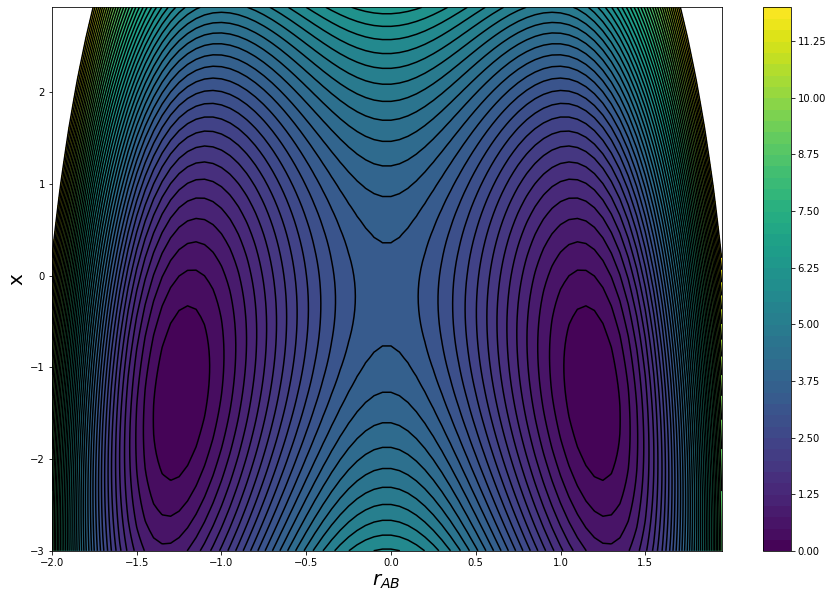

In [4]:
min_z = np.amin(zz)
max_z = np.amax(zz)
#plot_kwargs = {'levels': MaxNLocator(nbins = 500).tick_values(-5,100), 'cmap': 'Spectral'}
fig, axes = plt.subplots(1, 1, figsize = (15, 10), sharex = True, sharey = True)
c_f = axes.contourf(rrAB,xx,zz,levels=MaxNLocator(nbins = 50).tick_values(0,12))
axes.contour(rrAB,xx,zz, levels=MaxNLocator(nbins = 50).tick_values(0,12),colors=['black'])
fig.colorbar(c_f)
axes.set_ylabel('x',size=20)
axes.set_xlabel('$r_{AB}$',size=20)
plt.show()

E_const = -4.261072847040653 E_gs = -4.261072848040653
Minimum Action:  3.096344923801193


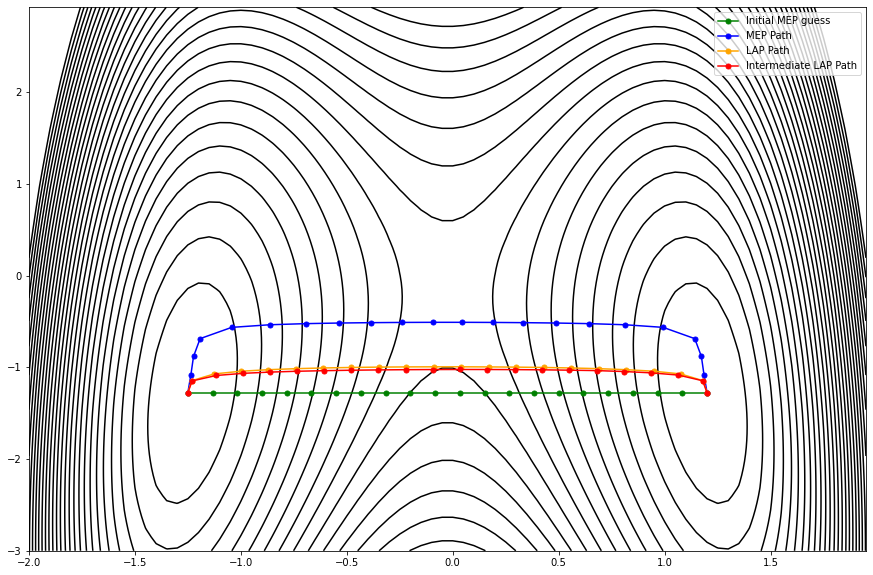

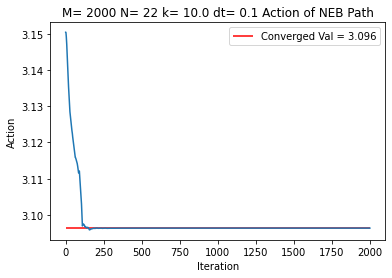

In [7]:
N = 22
M = 100
M_LAP = 2000
dt = .1
dt_LAP = .1
k = 10.0
kappa = 1.0

R0 = np.array((xx1,yy1)) ### ground state
RN = np.array((xx0,yy0)) ### metastable state.
init_path = get_init_path(R0,RN,N)
E_gs = min(V(xx0,yy0),V(xx1,yy1))-1e-9
E_const = V(xx0,yy0)
print('E_const = '+str(E_const), 'E_gs = '+str(E_gs))
MEP_path,action_array,tot_E = NEB_MEP(V,init_path,E_gs,M,N,dt,k)
LAP_path,LAP_action_array,LAP_tot_E,fullpath =  NEB_LAP(V,init_path,E_gs,E_const,M_LAP,N,dt_LAP,k,kappa,fix_r0=True,fix_rn=True,FIRE=True)

print("Minimum Action: ", LAP_action_array[-1])
np.savetxt("LAP_NEB.csv", LAP_path, delimiter=",")
fig, ax = plt.subplots(1,1,figsize = (15, 10))
im = ax.contour(rrAB,xx, zz, colors=['black'],levels=MaxNLocator(nbins = 50).tick_values(-5,12))                
ax.plot(init_path[:,0], init_path[:, 1], '.-', color = 'green',ms=10,label='Initial MEP guess')
ax.plot(MEP_path[:, 0], MEP_path[:, 1], '.-', color = 'blue',ms=10,label='MEP Path')
ax.plot(LAP_path[:, 0], LAP_path[:, 1], '.-', color = 'orange',ms=10,label='LAP Path')
ax.plot(fullpath[np.argmin(LAP_action_array),:, 0], fullpath[np.argmin(LAP_action_array),:, 1], '.-', color = 'red',ms=10,label='Intermediate LAP Path')
plt.legend()
plt.savefig('path_M_'+str(M_LAP)+'_N_'+str(N)+'_k_'+str(k)+'_dt_'+str(dt)+'.pdf')
plt.show()
"""
plt.plot(np.arange(0,M,1),tot_E)
plt.hlines(LAP_tot_E[-1],0,M,label='Min= '+str(tot_E[-1]),color='red')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('M= '+str(M)+' N= '+str(N)+' k= '+str(k)+' dt= '+str(dt)+' Total energy of NEB Path')
plt.legend()
#plt.savefig('TotalE_M_'+str(M)+'_N_'+str(N)+'_k_'+str(k)+'_dt_'+str(dt)+'.pdf')
plt.show()
"""
plt.plot(np.arange(0,M_LAP,1),LAP_action_array)
plt.hlines(LAP_action_array[-1],0,M_LAP,label='Converged Val = '+str(np.around(LAP_action_array[-1],3)),color='red')
plt.xlabel('Iteration')
plt.ylabel('Action')
plt.title('M= '+str(M_LAP)+' N= '+str(N)+' k= '+str(k)+' dt= '+str(dt)+' Action of NEB Path')
plt.legend()
plt.savefig('action_M_'+str(M_LAP)+'_N_'+str(N)+'_k_'+str(k)+'_dt_'+str(dt)+'.pdf')
plt.show()        